In [1]:
import sys
sys.path.insert(0,'/home/oem/Projects/Kylearn')
# Use this model from my newest repo
from Models.Attention.attn_model import Attn_model_2d
from Models.Attention.attn_model import Attn_model_2d_timeSeries
# Modify this dataset class or write your own
from Models.Attention.attn_dataset import Attn_dataset_2d
# Use this network
from Networks.residual_network import Resnet_2d
# import these evaluation and visualization lib from my repo
from evaluation.metrics import metrics_binary, auc_roc
from visualization.draw_matrix import draw_confusion_matrix
from visualization.draw_roc import plot_roc_curve
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", 50)

## Initialize hyperparameters, dataset, network and model


In [2]:
# past m days to predict n days ahead
m = 3
n = 2
# load dataset
# For attention model, there are 3 files to load, they are generated from ./create_dataset.py
# output num is the dimension of the label, for anomaly detection it should be 1
dataset = Attn_dataset_2d(feature_path='data/m%s_n%s_attn_features.npy'%(m, n),
                       dev_path= 'data/m%s_n%s_attn_devices.npy'%(m, n),
                       label_path='data/m%s_n%s_attn_labels.npy'%(m, n),
                       out_num=1)
# load network
resnet = Resnet_2d()

# load model
# In anomaly detection problem, output should be 1 if regression=True
model = Attn_model_2d(ckpt_path='models/attn_m%s'%m, tsboard_path='log/', network=resnet,input_shape=[m, 45, 1],
                   num_classes=1, feature_num=45, dev_num=11, lr=0.001, batch_size=100,
                   regression=True, threshold=0.99, patience=20)


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [ ]:

# -------------------------------------------------------------------------------------
# Training
# -------------------------------------------------------------------------------------

# # initialize model and train
# model.initialize_variables()
# model.save_tensorboard_graph()
# model.train(dataset)

## Testing

In [3]:
# Restore checkpoint using the step number
model.restore_checkpoint(700)

INFO:tensorflow:Restoring parameters from models/attn_m3-700


In [4]:
# get probability of an instance being an anomaly
prediction = model.get_proba(dataset.test_set[0:3])
prediction

array([[0.01999728],
       [0.19499396],
       [0.00688453]], dtype=float32)

In [5]:
# get probability of an instance being an anomaly
prediction = model.get_proba(dataset.test_set)
prediction[0:5]

array([[0.01999729],
       [0.19499402],
       [0.00688452],
       [0.03143608],
       [0.01241772]], dtype=float32)

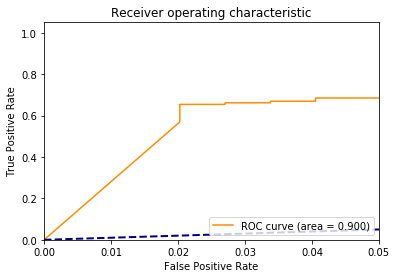

In [6]:
# calculate auc, false positive rates and etc.
auc, fprs, tprs, thresholds = auc_roc(
    y_pred=prediction, y_test=dataset.test_set['y']
)
# plot roc curve
plot_roc_curve(fprs, tprs, auc, x_axis=0.05)

accuracy: 0.8129496402877698

precision: 0.9642857142857143

recall: 0.6230769230769231

false positive rate: 0.02027027027027027



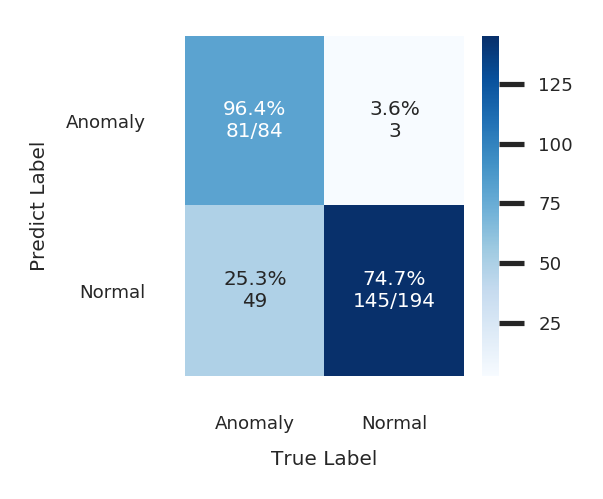

In [7]:
# move threshold from 0.9 to 0.9999 to see the change of fpr, acc and etc.
threshold = 0.999
cm, fpr, acc, precision, recall = metrics_binary(
    y_pred=prediction, y_test=dataset.test_set['y'],threshold=threshold)

import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300  # pixel
plt.rcParams['figure.dpi'] = 300  # resolution
plt.rcParams["figure.figsize"] = [1.5,1.5] # figure size
# draw cm
draw_confusion_matrix(cm, ['Normal', 'Anomaly'],
                      plt = plt, precision=True, 
                      font_size = 0.4, x_rotation = 0)

## Visualize attention layer

In [8]:
# name list of PM values
pm_list = ['BBE-RS',
            'CV-OTU', 'CV-S',
            'DROPGAINAVG-OTS', 'DROPGAINMAX-OTS_DROPGAINMIN-OTS_-',
            'E-CV', 'E-ES', 'E-INFRAMESERR_E-INFRAMES_/', 'E-OUTFRAMESERR_E-OUTFRAMES_/',
            'E-UAS', 'ES-OTU', 'ES-RS', 'ES-S',
            'OCH-OPRAVG', 'OCH-OPRMAX_OCH-OPRMIN_-', 'OCH-SPANLOSSAVG', 'OCH-SPANLOSSMAX_OCH-SPANLOSSMIN_-',
            'OPINAVG-OTS', 'OPINMAX-OTS_OPINMIN-OTS_-',
            'OPOUTAVG-OTS', 'OPOUTAVG-OTS_OPINAVG-OTS_-', 'OPOUTMAX-OTS_OPOUTMIN-OTS_-',
            'OPRAVG-OCH', 'OPRAVG-OTS', 'OPRMAX-OCH_OPRMIN-OCH_-', 'OPRMAX-OTS_OPRMIN-OTS_-',
            'OPTAVG-OCH', 'OPTAVG-OTS', 'OPTMAX-OCH_OPTMIN-OCH_-', 'OPTMAX-OTS_OPTMIN-OTS_-',
            'ORLAVG-OTS', 'ORLMIN-OTS', 'OTU-CV', 'OTU-ES', 'OTU-QAVG', 'OTU-QSTDEV',
            'PCS-CV', 'PCS-ES', 'PCS-UAS',
            'QAVG-OTU', 'QSTDEV-OTU',
            'RS-BBE', 'RS-ES',
            'S-CV', 'S-ES']

# device list
dev_list = ['AMP', 'ETH10G', 'ETHN', 'ETTP', 'OC192', 'OPTMON', 'OSC', 'OTM', 'OTM2', 'OTUTTP', 'PTP']

In [9]:
def visualize_input_attention_2d(matrix, pm_list):
    num = matrix.shape[0]
    index = np.arange(num)
    index = -np.flip(index)
    attn_matrix = pd.DataFrame(data=matrix, index=index, columns=pm_list)
    attn_matrix[attn_matrix == 1] = 0
    return attn_matrix

In [10]:
# diagonal matrix of 11-dim representing 11 device types
test_dev = np.diag(np.ones([11]))
test_dev

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [11]:
# output attentions, attn1 is the input attention and attn2 is the output attention
# attn2 is only works in classification problems
attn1, attn2 = model.get_attn_matrix(test_dev)

In [12]:
# attn1[0] is for `AMP`, attn1[1] is for `ETH10G` and so on, the order is the same with in `dev_list`
# Example: visualize attention matrix for device AMP
attn_matrix_AMP = visualize_input_attention_2d(
    attn1[0], pm_list)
attn_matrix_AMP

# The initial value in the attention matrix is 1.
# After learning, if some values are still 1, that implies the the corresponding PM is zero,
# and the value is not updated, thus we mask it as 0.

# The attention value, can be compared vertically (temporal importance) and horizontally (PM importance). 

,BBE-RS,CV-OTU,CV-S,DROPGAINAVG-OTS,DROPGAINMAX-OTS_DROPGAINMIN-OTS_-,E-CV,E-ES,E-INFRAMESERR_E-INFRAMES_/,E-OUTFRAMESERR_E-OUTFRAMES_/,E-UAS,ES-OTU,ES-RS,ES-S,OCH-OPRAVG,OCH-OPRMAX_OCH-OPRMIN_-,OCH-SPANLOSSAVG,OCH-SPANLOSSMAX_OCH-SPANLOSSMIN_-,OPINAVG-OTS,OPINMAX-OTS_OPINMIN-OTS_-,OPOUTAVG-OTS,OPOUTAVG-OTS_OPINAVG-OTS_-,OPOUTMAX-OTS_OPOUTMIN-OTS_-,OPRAVG-OCH,OPRAVG-OTS,OPRMAX-OCH_OPRMIN-OCH_-,OPRMAX-OTS_OPRMIN-OTS_-,OPTAVG-OCH,OPTAVG-OTS,OPTMAX-OCH_OPTMIN-OCH_-,OPTMAX-OTS_OPTMIN-OTS_-,ORLAVG-OTS,ORLMIN-OTS,OTU-CV,OTU-ES,OTU-QAVG,OTU-QSTDEV,PCS-CV,PCS-ES,PCS-UAS,QAVG-OTU,QSTDEV-OTU,RS-BBE,RS-ES,S-CV,S-ES
-2,0.0,0.0,0.0,0.767717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.099396,0.944771,0.990731,1.126749,0.770649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.932124,1.029639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1,0.0,0.0,0.0,0.783888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.101041,0.858582,0.989438,1.129164,0.923924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.931953,0.995252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.961006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.980586,0.923873,1.032953,1.102413,1.100614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.918649,1.005489,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Example: visualize attention matrix for device OPTMON
attn_matrix_OPTMON = visualize_input_attention_2d(
    attn1[5], pm_list)
attn_matrix_OPTMON

,BBE-RS,CV-OTU,CV-S,DROPGAINAVG-OTS,DROPGAINMAX-OTS_DROPGAINMIN-OTS_-,E-CV,E-ES,E-INFRAMESERR_E-INFRAMES_/,E-OUTFRAMESERR_E-OUTFRAMES_/,E-UAS,ES-OTU,ES-RS,ES-S,OCH-OPRAVG,OCH-OPRMAX_OCH-OPRMIN_-,OCH-SPANLOSSAVG,OCH-SPANLOSSMAX_OCH-SPANLOSSMIN_-,OPINAVG-OTS,OPINMAX-OTS_OPINMIN-OTS_-,OPOUTAVG-OTS,OPOUTAVG-OTS_OPINAVG-OTS_-,OPOUTMAX-OTS_OPOUTMIN-OTS_-,OPRAVG-OCH,OPRAVG-OTS,OPRMAX-OCH_OPRMIN-OCH_-,OPRMAX-OTS_OPRMIN-OTS_-,OPTAVG-OCH,OPTAVG-OTS,OPTMAX-OCH_OPTMIN-OCH_-,OPTMAX-OTS_OPTMIN-OTS_-,ORLAVG-OTS,ORLMIN-OTS,OTU-CV,OTU-ES,OTU-QAVG,OTU-QSTDEV,PCS-CV,PCS-ES,PCS-UAS,QAVG-OTU,QSTDEV-OTU,RS-BBE,RS-ES,S-CV,S-ES
-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.932056,0.0,1.013041,0.0,0.978872,0.0,1.546064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.927294,0.0,1.432178,0.0,0.983716,0.0,1.497844,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.918313,0.0,1.072725,0.0,0.966663,0.0,1.341753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
